In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
from keras import metrics
from tabulate import tabulate
import matplotlib.pyplot as plt
from multiprocessing import Pool
from random import randint
from typing import Any, Dict, List, Sequence
import time

import numpy.typing as npt
!pip install scaaml
from scaaml.aes import ap_preds_to_key_preds
from scaaml.plot import plot_trace, plot_confusion_matrix



In [3]:
from typing import Sequence, List
import numpy.typing as npt


def pretty_hex(e: int) -> str:
    """Representation of an integer as a zero-padded two-digit hex string."""
    return f"{e:02X}"


def hex_line(chars: Sequence[int], spacer: str = " ") -> str:
    """Render some chars as hex with a spacer between them"""
    h = []
    for e in chars:
        h.append(pretty_hex(e))
    return spacer.join(h)


def hex_display(lst: Sequence[int],
                prefix: str = "",
                color: str = "green") -> None:
    """Display a list of int as colored hex."""
    h = []
    for e in lst:
        h.append(pretty_hex(e))
    hex_representation = prefix + " ".join(h)
    # Assuming you print with some styled color effect
    print(f"{color}: {hex_representation}")  # Example use of the 'color' parameter

def from_categorical(predictions: Sequence[npt.ArrayLike]) -> List[np.intp]:
    "reverse of categorical"
    # note: doing it as a list is significantly faster than a single argmax
    return [np.argmax(p) for p in predictions]


In [4]:
ATTACK_POINT = 'sub_bytes_in'

# let's also pick the key byte we want to use SCAAML to recover and load the related model
ATTACK_BYTE = 0

In [5]:
import src.DAT255_SCA.utils.dataset_utils as utils
file_path = "../datasets/attack_set.hdf5"
utils.close_file(file_path)
utils.create_dataset(file_path, 4096, 1, "attack")

(4096, 16) (4096, 16)


In [6]:

#importing the models
from keras.models import Model
import tensorflow as tf

model5000 = tf.keras.models.load_model("../models/stm32f0-tinyaes-cnn-v10-ap_sub_bytes_in-byte_0-len_5000.keras")
model = tf.keras.models.load_model("../models/first_scaaml_model_on_our_data.keras")
#no use for this as our data only has range 5000
#model20000 = tf.keras.models.load_model("stm32f0-tinyaes-cnn-v10-ap_sub_bytes_in-byte_0-len_20000.keras")

In [9]:
import src.DAT255_SCA.utils.dataset_utils as utils
NUM_TRACES = 10  # maximum number of traces to use to recover a given key byte. 10 is already overkill
correct_prediction_rank = defaultdict(list)
y_pred = []
y_true = []
model_metrics = {"acc": metrics.Accuracy()}
file_path = "../datasets/attack/attack_0.hdf5"

#for løkken må endres fordi metoden returnerer en liste av alt
#heller iterere over i, siden første plassen i listen er all info for "shard 1"
x = []
y = []
keys = []
pts = []

x, y, keys, pts = utils.load_and_prepare_dataset_for_evaluation(file_path, ATTACK_BYTE, ATTACK_POINT, num_traces=NUM_TRACES)

for i in tqdm(range(len(x)), desc='Recovering bytes', unit='shards'):

    # prediction
    predictions = model.predict(x[i])

    # computing byte prediction from intermediate predictions
    key_preds = ap_preds_to_key_preds(predictions, pts[i], ATTACK_POINT)

    c_preds = from_categorical(predictions)
    c_y = from_categorical(y[i])
    #mye som tyder på at den har 10 like hver gang...
    print(c_preds)
    print(c_y)

    # metric tracking
    for metric in model_metrics.values():
        metric.update_state(c_y, c_preds)
    # for the confusion matrix
    y_pred.extend(c_preds)
    y_true.extend(c_y)

    # accumulating probabilities and checking correct guess position.
    # if all goes well it will be at position 0 (highest probability)
    # see below on how to use for the real attack

    #tror denne også må være i
    key = keys[i][0] # all the same in the same shard - not used in real attack
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22)
        guess_ranks = (np.argsort(vals, )[-256:][::-1])
        byte_rank = list(guess_ranks).index(key)
        correct_prediction_rank[trace_count].append(byte_rank)
    #maxed out ram before i added this, not sure of the actual effect or if it was random
    del predictions, key_preds, c_preds, c_y

Recovering bytes:   0%|          | 0/4096 [00:00<?, ?shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[141]
[122]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
[105]
[90]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
[57]
[151]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
[207]
[121]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
[33]
[13]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
[176]
[39]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
[136]
[144]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
[70]
[30]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
[232]
[169]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
[112]
[106]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
[136]
[136]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
[130]
[142]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
[244]
[125]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
[218]
[127]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
[150]
[165]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
[170]
[63]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
[168]
[104]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
[180]
[206]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
[232]
[91]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
[234

KeyboardInterrupt: 

In [10]:
print("Accuracy: %.2f" % model_metrics['acc'].result())


Accuracy: 0.11


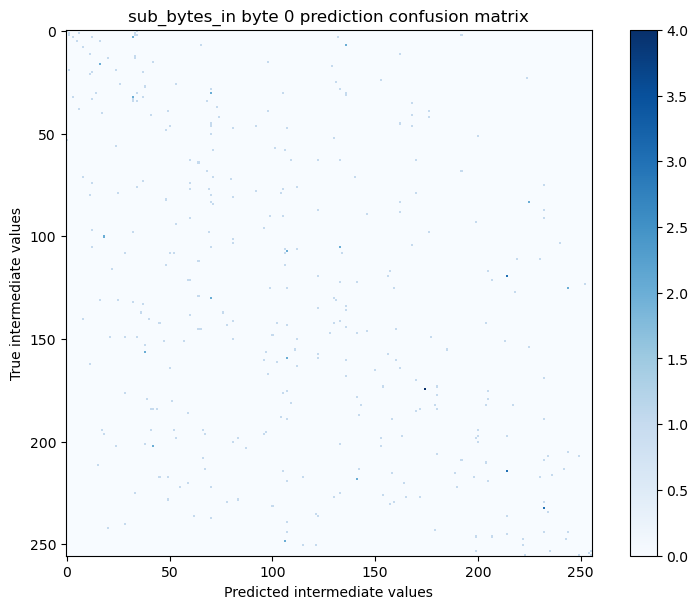

In [12]:
plot_confusion_matrix(y_true, y_pred, normalize=True, title="%s byte %s prediction confusion matrix" % (ATTACK_POINT, ATTACK_BYTE))


In [13]:
config = """{
    "model": "cnn",
    "device": "stm32f415",
    "algorithm": "tinyaes",
    "version": "10",
    "attack_points": [
        "sub_bytes_out",
        "sub_bytes_in",
        "key"
    ],
    "attack_bytes": [
        "0",
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "8",
        "9",
        "10",
        "11",
        "12",
        "13",
        "14",
        "15"
    ],
    "max_trace_len": 20000,
    "num_shards": 256,
    "num_traces_per_shard": 256,
    "batch_size": 32,
    "epochs": 30,
    "optimizer_parameters": {
        "lr": 0.001,
        "multi_gpu_lr": 0.001
    },
    "model_parameters": {
        "activation": "relu",
        "initial_filters": 8,
        "initial_pool_size": 4,
        "block_kernel_size": 3,
        "blocks_stack1": 3,
        "blocks_stack2": 4,
        "blocks_stack3": 4,
        "blocks_stack4": 3,
        "dense_dropout": 0.1
    }
}"""
target_config = json.loads(config)


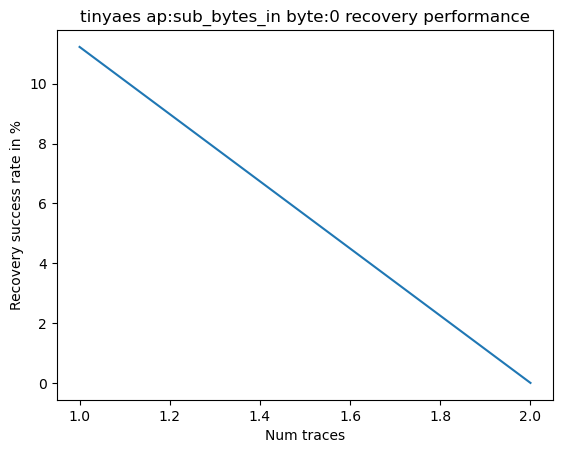

In [16]:
NUM_TRACES_TO_PLOT = 2
avg_preds = np.array([correct_prediction_rank[i].count(0) for i in range(NUM_TRACES_TO_PLOT)])
y = avg_preds / len(correct_prediction_rank[0]) * 100
x = [i + 1 for i in range(NUM_TRACES_TO_PLOT)]
plt.plot(x, y)
plt.xlabel("Num traces")
plt.ylabel("Recovery success rate in %")
plt.title("%s ap:%s byte:%s recovery performance" % (target_config['algorithm'], ATTACK_POINT, ATTACK_BYTE))
plt.show()

In [17]:
min_traces = 0
max_traces = 0
cumulative_aa = 0
for idx, val in enumerate(y):
    cumulative_aa += val
    if not min_traces and val > 0:
        min_traces = idx + 1
    if not max_traces and val == 100.0:
        max_traces = idx + 1
        break

cumulative_aa = round( cumulative_aa / (idx + 1), 2) # divide by the number of steps

rows = [
    ["min traces", min_traces, round(y[min_traces -1 ], 1)],
    ["max traces", max_traces, round(y[max_traces - 1], 1)],
    ["cumulative score", cumulative_aa, '-']
]
print(tabulate(rows, headers=['metric', 'num traces', '% of keys']))

metric              num traces  % of keys
----------------  ------------  -----------
min traces                1     11.2
max traces                0     0.0
cumulative score          5.61  -


In [16]:
ATTACK_POINT = 'sub_bytes_in' # let's pick an attack point- Key is not a good target: it doesn't work for TinyAEs
TARGET_SHARD = 5 # a shard == a different key. Pick the one you would like
NUM_TRACES = 14  # how many traces to use - as seen in single byte, 5 traces is enough

In [15]:
# perfoming 16x the byte recovery algorithm showecased above - one for each key byte
real_key = [] # what we are supposed to find
recovered_key = [] # what we predicted
pb = tqdm(total=16, desc="guessing key", unit='guesses')
for ATTACK_BYTE in range(16):
    # data
    keys, pts, x, y = load_attack_shard(shard_paths[TARGET_SHARD], ATTACK_BYTE, ATTACK_POINT, TRACE_LEN, num_traces=NUM_TRACES, full_key=True)
    real_key.append(keys[0])
    x = x[:,:5000,:]
    # load model
    model = model5000

    # prediction
    predictions = model.predict(x)

    # computing byte prediction from intermediate predictions
    key_preds = ap_preds_to_key_preds(predictions, pts, ATTACK_POINT)

    # accumulating probabity
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22)

    # order predictions by probability
    guess_ranks = (np.argsort(vals, )[-256:][::-1])

    # take strongest guess as our key guess
    recovered_key.append(guess_ranks[0])

    # update display
    pb.set_postfix({'Recovered key': bytelist_to_hex(recovered_key), "Real key": bytelist_to_hex(real_key)})
    pb.update()


pb.close()

guessing key:   0%|          | 0/16 [00:00<?, ?guesses/s]

NameError: name 'load_attack_shard' is not defined

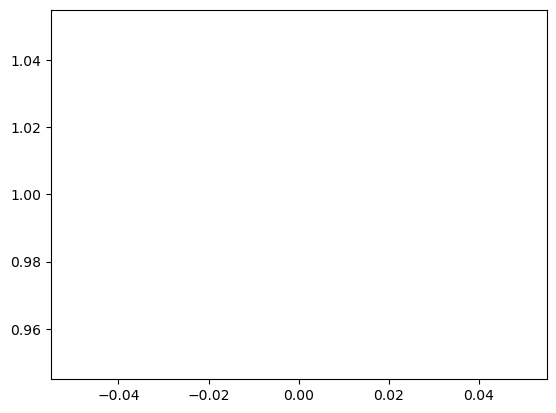

In [109]:
plt.plot(x[0])
plt.show()

AttributeError: 'int' object has no attribute 'shape'

In [32]:
#FEILSØKER METODEN
import src.DAT255_SCA.utils.dataset_utils as utils

file_path = "../datasets/test/test_0.hdf5"
ATTACK_BYTE = 0
ATTACK_POINT = "sub_bytes_in"
NUM_TRACES = 10
x, y, keys, pts = utils.load_and_prepare_dataset_for_evaluation(file_path, ATTACK_BYTE, ATTACK_POINT, num_traces=NUM_TRACES)

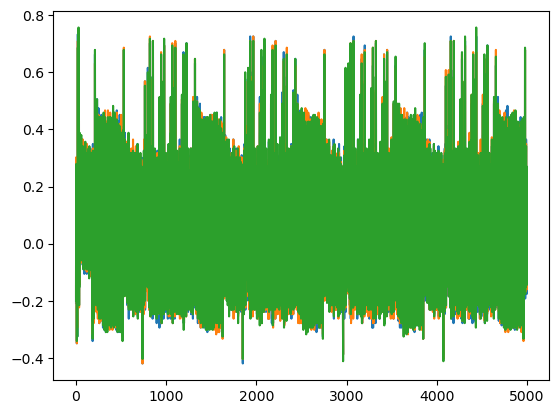

In [18]:
import matplotlib.pyplot as plt
plt.plot(x[0][0])
plt.plot(x[0][1])
plt.plot(x[0][2])

In [33]:
keys

[array([123, 123, 123, 123, 123, 123, 123, 123, 123, 123], dtype=uint8),
 array([57, 57, 57, 57, 57, 57, 57, 57, 57, 57], dtype=uint8),
 array([156, 156, 156, 156, 156, 156, 156, 156, 156, 156], dtype=uint8),
 array([48, 48, 48, 48, 48, 48, 48, 48, 48, 48], dtype=uint8),
 array([204, 204, 204, 204, 204, 204, 204, 204, 204, 204], dtype=uint8),
 array([41, 41, 41, 41, 41, 41, 41, 41, 41, 41], dtype=uint8),
 array([176, 176, 176, 176, 176, 176, 176, 176, 176, 176], dtype=uint8),
 array([167, 167, 167, 167, 167, 167, 167, 167, 167, 167], dtype=uint8),
 array([97, 97, 97, 97, 97, 97, 97, 97, 97, 97], dtype=uint8),
 array([189, 189, 189, 189, 189, 189, 189, 189, 189, 189], dtype=uint8),
 array([235, 235, 235, 235, 235, 235, 235, 235, 235, 235], dtype=uint8),
 array([105, 105, 105, 105, 105, 105, 105, 105, 105, 105], dtype=uint8),
 array([141, 141, 141, 141, 141, 141, 141, 141, 141, 141], dtype=uint8),
 array([84, 84, 84, 84, 84, 84, 84, 84, 84, 84], dtype=uint8),
 array([153, 153, 153, 153, 

In [37]:
keys[1][3]

57

In [45]:
y[0]


<tf.Tensor: shape=(10, 256), dtype=uint8, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)>

In [46]:
y[1]

<tf.Tensor: shape=(10, 256), dtype=uint8, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)>

In [ ]:
utils.new_inspect(file_path)

In [ ]:
#Her er de tre først nøklene so vi forventer å finne i gruppe 1, 2 og 3
[123 212  64 231 103 136  38 171 145  68 207 235  35  71 173  84]
[ 57 170 230  85  32 242 235  10  99 189  98  40 225  24  61 217]
[ 47 214  59 232 208  22  62  83 138 221  47  92 206 241  13 118]
